# Classificazione di cellulari in fasce di prezzo

**Progetto di Programmazione di Applicazioni Data Intensive  
Anno Accademico 2021/2022**

Lorenzo Zanetti  
matricola: 0000933486  
lorenzo.zanetti5@studio.unibo.it

In [1]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Caso di studio

I dati su cui si vuole creare un modello provengono dal sito Kaggle (più precisamente da [qui](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?resource=download&select=train.csv)) e descrivono una serie di diversi modelli di telefoni classificati in una fascia di prezzo specifica.

In [2]:
data = pd.read_csv("data.csv")
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In questo caso leggendo il file con Pandas senza specificare altro otteniamo il risultato desiderato: come indice delle righe viene aggiunta una nuova colonna (non erano presenti id univoci nel dataset) e come nomi delle colonne vengono dati quelli di "default" specificati nella prima riga del file .csv  
L'unico problema è che di default Pandas mostra massimo 20 colonne (le prime e le ultime 10) per cui nel nostro caso verrebbe "nascosta" una sola colonna, quindi specifichiamo di volerne visualizzare 21.

In [3]:
len(data.columns)

21

In [4]:
pd.options.display.max_columns = 21
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


Come notiamo la quantità di dati non è molto elevata, per cui ci aspettiamo di poter lavorare con il dataset completamente in memoria senza usare strategie di "risparmio" di memoria.

In [5]:
len(data)

2000

Nel nostro caso la variabile da predire è **price_range**, l'ultima colonna, per cui per comodità la mettiamo come prima.  
Questa variabile è discreta e può assumere 4 valori, cioè 4 possibili fasce di prezzo:  

0. Bassa
1. Media
2. Alta
3. Molto alta

La variabile da predire è quindi discreta multivariata.

In [6]:
columns_names = data.columns.to_list()
columns_names.insert(0, columns_names.pop(-1))
data = data.reindex(columns=columns_names)
data.head()

,price_range,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,2,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,2,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0


Le altre feature indicano rispettivamente:  
- **battery_power**: capienza batteria in milliampereora
- **blue**: ha bluetooth (1) o no (0)
- **clock_speed**: velocità del microprocessore
- **dual_sim**: può montare 2 sim (1) o no (0)
- **fc**: mega pixel della fotocamera frontale (0 se non ce l'ha)
- **four_g**: ha il 4G (1) o no (0)
- **int_memory**: memoria interna in giga bytes
- **m_dep**: spessore del cellurare in cm
- **mobile_wt**: peso del cellulare in grammi
- **n_cores**: numero di core del processore
- **pc**: mega pixel della fotocamera principale
- **px_height** e **px_width**: risoluzione in pixel, altezza e larghezza
- **ram**: memoria ram in mega bytes
- **sc_h** e **sc_w**: altezza e larghezza schermo in cm
- **talk_time**: durata della batteria durante una chiamata (in ore)
- **three_g**: ha il 3G (1) o no (0)
- **touch_screen**: è touch (1) o no (0)
- **wifi**: ha il wifi (1) o no (0)

Come notiamo dall'elenco delle feature abbiamo 6 **variabili discrete binarie** e le restanti 14 **variabili continue**.

In [7]:
binary_feature = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]
continuos_feature = data.columns.to_list()
for b in binary_feature:
    continuos_feature.remove(b)
continuos_feature.remove("price_range")
continuos_feature

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [8]:
#controlliamo siamo 14
len(continuos_feature)

14

## Analisi esplorativa

Iniziamo vedendo come sono distribuite le fasce di prezzo e quindi come è distribuita la varibile target.

<AxesSubplot:>

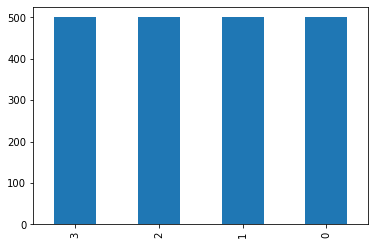

In [9]:
data["price_range"].value_counts().plot.bar()

La distribuzione dei telefoni nelle varie fasce di prezzo è **perfettamente bilanciata**, questo mi fa pensare che il dataset sia poco "realistico" e probabilmente realizzato in modo "artificiale". Questo non esclude però che si possa cercare un modello analizzando questi dati, e il fatto che la variabile target sia così equamente distribuita può soltanto aiutare a trovare un modello migliore.

Vediamo ora la distribuzione di alcune feature, per esempio quelle binarie.

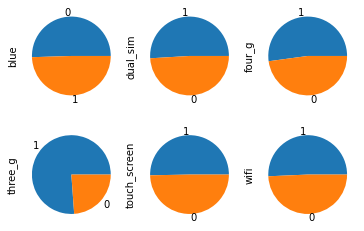

In [10]:
for i, f in enumerate(binary_feature, 1):
    plt.subplot(2, 3, i)
    data[f].value_counts().plot.pie()

Da qui notiamo che circa **la metà** dei cellulari ha il bluetooth e l'altra metà no. Stessa cosa vale per la doppia sim, il 4G, il touch screen e il wifi. Invece ad avere il 3G sono circa i **3/4** dei telefoni, contro l'**1/4** che non ce l'ha.

Proviamo a vedere invece dati più dettagliati riguardanti la capacità della batteria e la velocità del processore.

In [11]:
data["battery_power"].describe()

count    2000.000000
mean     1238.518500
std       439.418206
min       501.000000
25%       851.750000
50%      1226.000000
75%      1615.250000
max      1998.000000
Name: battery_power, dtype: float64

<AxesSubplot:>

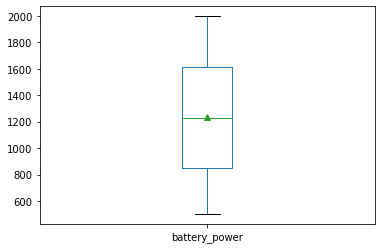

In [12]:
data["battery_power"].plot.box(showmeans=True)

<AxesSubplot:>

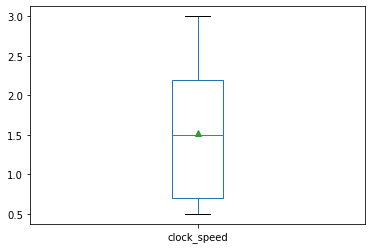

In [13]:
data["clock_speed"].plot.box(showmeans=True)

Come ci si può aspettare da questo tipo di specifiche i dati sono distribuiti in modo abbastanza "standard", per esempio **non** sono presenti **outliers** nei box plot, d'altra parte ci sembrerebbe strano trovare un unico micro processore di molto superiore agli altri come velocità (es. 4ghz), specialmente in un dataset non troppo recente.
Le batterie vanno da 500 a 2000 mAh con una media di ~1200 e sono distribuite in **modo piuttosto uniforme** guardando 25° e 75° percentile, mentre la maggior parte dei microprocessori si trova spostata verso l'estremo inferiore (il 75° percentile è lontano dal massimo mentre il 25° è vicino al minimo).

Proviamo ora a vedere la distribuzione di alcune variabili rispetto alla variabile target della fascia di prezzo.

[Text(0.5, 0, 'RAM')]

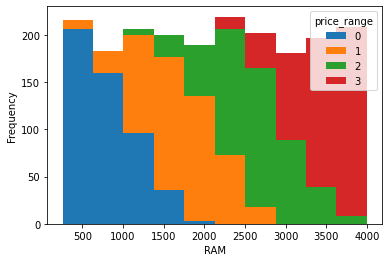

In [14]:
data.pivot(columns="price_range")["ram"].plot.hist(bins=10, stacked=True).set(xlabel="RAM")

[Text(0.5, 0, 'Capacità batteria')]

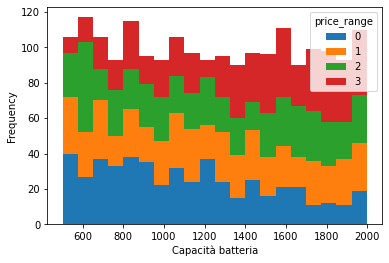

In [15]:
data.pivot(columns="price_range")["battery_power"].plot.hist(bins=20, stacked=True).set(xlabel="Capacità batteria")

Come notiamo dal primo grafico all'**aumentare di prezzo è maggiore la grandezza della memoria RAM**, mentre dal secondo si nota che anche la capacità della batteria ha un'influenza sul prezzo, anche se molto minore.  

In [16]:
data.groupby(["price_range", "four_g"]).size()

price_range  four_g
0            0         241
             1         259
1            0         238
             1         262
2            0         253
             1         247
3            0         225
             1         275
dtype: int64

In [17]:
data.groupby(["price_range", "wifi"]).size()

price_range  wifi
0            0       252
             1       248
1            0       248
             1       252
2            0       248
             1       252
3            0       238
             1       262
dtype: int64

Mentre dalle due tabelle che considerano rispettivamente la presenza del **4G** o del **wifi** nel telefono si nota che tendenzialmente un telefono più costoso ha più probabilità di avere questi optional.

In [18]:
range_colors_map = {0: "blue", 1: "orange", 2: "green", 3:"red"}
range_colors = data["price_range"].map(range_colors_map)

<AxesSubplot:xlabel='battery_power', ylabel='ram'>

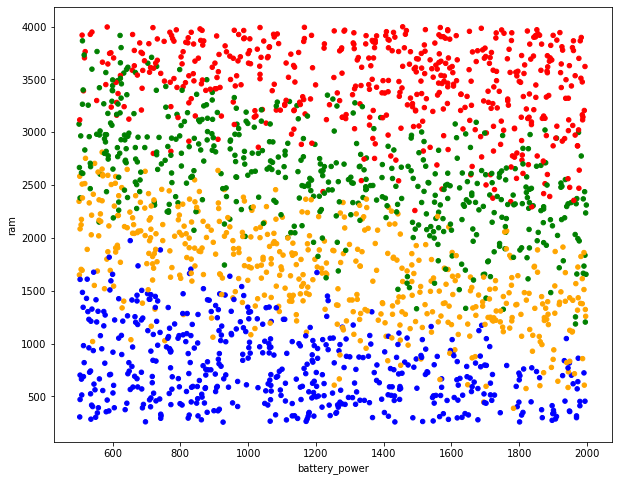

In [19]:
data.plot.scatter("battery_power", "ram", c=range_colors, figsize=(10, 8))

Grazie allo scatter plot e ai colori usati come indicatori della fascia di prezzo (blue: bassa, giallo: media, verde: alta, rosso: molto alta) riusciamo a vedere come influiscono 2 diverse feature (RAM e capienza batteria) sulla fascia di prezzo.

In [20]:
pd.DataFrame(np.where(data.corr().abs() >= 0.05, data.corr(), np.nan), columns=data.columns, index=data.columns)

,price_range,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
price_range,1.000000,0.200723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.148858,0.165818,0.917046,NaN,NaN,NaN,NaN,NaN,NaN
battery_power,0.200723,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05251,NaN,NaN,NaN
blue,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clock_speed,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dual_sim,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fc,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.644595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
four_g,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584246,NaN,NaN
int_memory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m_dep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile_wt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Con la funzione **corr** di Pandas ci viene restituita una tabella con indicata la correlazione di ogni feature con ciascuna delle altre. Essendoci molte feature ho preferito impostare a NaN le correlazioni inferiori ad una certa soglia (0,05) per leggere con più semplicità le correlazioni più rilevanti.  

Notiamo come le 4 feature che incidono di più sul prezzo siano in ordine di importanza: RAM, capienza della batteria, pixel orizzontali e pixel verticali, quindi diciamo **RAM**, **batteria** e **risoluzione**, tutte caratteristiche effettivamente sensate.  

Oltre a questo si vede come i megapixel della fotocamera principale e di quella frontale siano molto correlati, oppure la larghezza in pixel con l'altezza o anche la larghezza dello schermo in centimetri con l'altezza.  
Altre correlazioni che risultano meno rilevanti, ma che comunque possono sembrare sensate sono anche la capienza della batteria con la durata del cellulare durante una chiamata o la presenza del 3G con quella del 4G.

In [21]:
data.corr().iloc[0]

price_range      1.000000
battery_power    0.200723
blue             0.020573
clock_speed     -0.006606
dual_sim         0.017444
fc               0.021998
four_g           0.014772
int_memory       0.044435
m_dep            0.000853
mobile_wt       -0.030302
n_cores          0.004399
pc               0.033599
px_height        0.148858
px_width         0.165818
ram              0.917046
sc_h             0.022986
sc_w             0.038711
talk_time        0.021859
three_g          0.023611
touch_screen    -0.030411
wifi             0.018785
Name: price_range, dtype: float64

Qui vediamo la correlazione di ogni feature con la variabile target e possiamo notare che caratteristiche dei cellulari come lo spessore del cellulare, la velocità di clock e il numero di core siamo **poco influenti** sul prezzo.

## Aggiunta nuove feature

In questo breve paragrafo vediamo l'aggiunta di potenziali nuove feature al dataset, derivate direttamente da quelle già presenti. Cercheremo di capire la loro potenziale rilevanza e il loro utilizzo.

In [22]:
mod_data = data.copy()
mod_data["px_res"] = mod_data["px_height"] * mod_data["px_width"]
mod_data.corr().iloc[-1]

price_range      0.176240
battery_power    0.018442
blue            -0.015513
clock_speed     -0.009854
dual_sim        -0.017730
fc              -0.012337
four_g          -0.009064
int_memory       0.015263
m_dep            0.025138
mobile_wt       -0.006036
n_cores          0.001245
pc              -0.017451
px_height        0.952730
px_width         0.684062
ram             -0.006357
sc_h             0.058362
sc_w             0.046496
talk_time       -0.010729
three_g         -0.028219
touch_screen     0.017036
wifi             0.044482
px_res           1.000000
Name: px_res, dtype: float64

In [23]:
mod_data["sc_dim"] = mod_data["sc_h"] * mod_data["sc_w"]
mod_data.corr().iloc[-1]

price_range      0.041248
battery_power   -0.024589
blue            -0.005565
clock_speed     -0.006103
dual_sim        -0.015703
fc              -0.011437
four_g           0.037167
int_memory       0.022887
m_dep           -0.021453
mobile_wt       -0.026375
n_cores          0.021618
pc              -0.013611
px_height        0.053894
px_width         0.041354
ram              0.033335
sc_h             0.656031
sc_w             0.959617
talk_time       -0.026502
three_g          0.033600
touch_screen     0.008131
wifi             0.043587
px_res           0.057003
sc_dim           1.000000
Name: sc_dim, dtype: float64

Nei precedenti due blocchi di codice vediamo l'aggiunta di due possibili nuove feature e la loro correlazione con le altre: **px_res** indica il numero totale di pixel presenti sullo schermo e **sc_dim** indica l'area dello schermo in cm. Queste due variabili possono servire per il fatto che le due coppie di variabili da cui le otteniamo sono **fortemente correlate** tra loro (altezza e larghezza, dei pixel e dello schermo in cm) e potrebbero portare ad effetti di **collinearità**.  
Queste due nuove variabili hanno anche una correlazione con la varibile target più alta delle due da cui sono state ottenute, se prese singolarmente, per cui potremmo avere effetti positivi aggiungerle al dataset (o sostituirle a quelle da cui sono state derivate).

In [24]:
mod_data["lin_speed"] = mod_data["clock_speed"] / mod_data["n_cores"]
mod_data.corr().iloc[-1]

price_range      0.006971
battery_power    0.043162
blue             0.000899
clock_speed      0.508728
dual_sim         0.001804
fc               0.006935
four_g          -0.026332
int_memory       0.032706
m_dep            0.016081
mobile_wt        0.015328
n_cores         -0.637533
pc               0.005690
px_height       -0.009270
px_width        -0.021559
ram              0.012426
sc_h            -0.028777
sc_w            -0.015185
talk_time       -0.013994
three_g         -0.044389
touch_screen     0.003578
wifi            -0.012037
px_res          -0.011120
sc_dim          -0.016878
lin_speed        1.000000
Name: lin_speed, dtype: float64

Qui vediamo un altro esempio riguardante per esempio la velocità di calcolo seriale, supponendo che clock_speed si riferisca alla massima velocità raggiungibile dal processore, utilizzando tutti i core.  

Notiamo che le variabili **px_res** e **sc_dim** potrebbero avere effetti positivi, mentre **lin_speed** sembra che sia poco impattante.  
Per il momento decido di mantere il dataset "pulito", per semplicità, e nel caso non ottenga buoni risultati valuterò di utilizzare effettivamente queste varibili.

## Preprocessing

I nostri dati non hanno valori **nulli o mancanti**, per cui non ci dobbiamo preoccupare di questo aspetto.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [26]:
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 21 entries, price_range to wifi
dtypes: float64(2), int64(19)
memory usage: 328.2 KB


Come possiamo notare Pandas non ha riconosciuto le variabili categoriche come tali, per cui provvediamo ad una modifica manuale.

In [27]:
data[binary_feature + ["price_range"]] = data[binary_feature + ["price_range"]].astype("category")
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 21 entries, price_range to wifi
dtypes: category(7), float64(2), int64(12)
memory usage: 233.3 KB


Notiamo anche un risparmio di quasi il **30% di memoria**.

In [28]:
data["price_range"]

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: category
Categories (4, int64): [0, 1, 2, 3]

A questo punto vogliamo dividere i nostri dati in variabili indipendeti e variabile target, quindi dividere questi dati in **training set** e **validation set**.

In [29]:
y = data["price_range"]
X = data.drop(columns="price_range")

X_train, X_val, y_train, y_val = train_test_split(
    X, y,             # dati da suddividere
    test_size=1/3,    # 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Iniziamo creandoci un semplice modello utilizzando il **Perceptron**.

In [30]:
model = Perceptron(random_state=42)

In [31]:
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.5247376311844077

In [32]:
(model.predict(X_val) == y_val).mean()

0.5247376311844077

Come notiamo la funzione **score** del modello ci restituisce semplicemente la percentuale di istanze classificate correttamente. In questo caso poco più della metà, che considerando la presenza di quattro classi, non è un brutto risultato inziale (classificando casualmente si otterrebbe **0.25** di score).

In [33]:
model.coef_

array([[-1.4120e+03,  3.2100e+02,  1.1639e+03,  3.9900e+02,  1.6620e+03,
         2.8200e+02,  1.5944e+04,  2.8280e+02,  5.2122e+04,  3.2190e+03,
         6.0770e+03, -3.8700e+03,  2.0900e+03, -5.9570e+03,  8.1250e+03,
         3.6480e+03,  6.0860e+03,  3.9600e+02,  4.3800e+02,  2.8200e+02],
       [ 2.3800e+02,  8.1000e+01, -2.0000e+00,  1.0700e+02, -3.0700e+02,
         9.7000e+01,  6.2030e+03,  1.7770e+02,  6.6260e+03, -1.3100e+02,
         5.7000e+02, -1.0790e+03, -1.3890e+03, -1.3630e+03,  8.9300e+02,
         2.1600e+02,  2.9500e+03,  1.0200e+02,  7.2000e+01,  1.5600e+02],
       [-3.4240e+03, -8.5000e+01, -1.4590e+02, -1.6000e+02,  1.6640e+03,
        -1.3900e+02, -1.1753e+04, -1.3490e+02, -5.1000e+03, -6.8000e+01,
         9.1500e+02,  1.4340e+03, -1.5000e+03,  2.5850e+03, -2.6520e+03,
        -4.0700e+02, -1.9510e+03, -4.9000e+01, -9.7000e+01, -1.5000e+02],
       [ 2.0400e+02, -3.3800e+02, -1.1582e+03, -3.6700e+02, -3.4960e+03,
        -2.7200e+02, -1.6052e+04, -2.8830e+02, -

In [34]:
model.intercept_

array([ 684.,   84., -124., -733.])

Come possiamo vedere i **paramentri** trovati dal Perceptron sono 80 coefficienti e 4 intercette, che quindi descrivono 4 **iperpiani** in uno spazio a 20 dimensioni: le nostre 20 varibili indipendenti.

Per realizzare un modello migliore la prima idea è quella di **standardizzare** i dati. Questo sembra molto utile considerando che alcune feature sono nell'ordine di grandezza 10<sup>-1</sup> e altre 10<sup>3</sup>.
Questo può aiutare anche con una maggiore generalizzazione del modello.

In [35]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("class", Perceptron(random_state=42))
])

In [36]:
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.6911544227886057

Vediamo come questo comporti un grande miglioramento nello score del modello, a questo punto proviamo ad effettuare della **regolarizzazione**, utilizzando per esempio **l1**.

In [37]:
for a in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("class", Perceptron(penalty="l1", alpha=a, random_state=42))
    ])
    model.fit(X_train, y_train)
    print("alpha: " + str(a) + " score: " + str(model.score(X_val, y_val)))

alpha: 0.1 score: 0.24737631184407796
alpha: 0.01 score: 0.6071964017991005
alpha: 0.001 score: 0.7361319340329835
alpha: 0.0001 score: 0.7736131934032984
alpha: 1e-05 score: 0.7271364317841079


Come notiamo provando diversi valori per l'iperparametro **alpha** otteniamo il risultato migliore con **0.0001**, migliorando ancora una volta i risultati ottenuti precedentemente.

In [38]:
model = Pipeline([
        ("scaler", StandardScaler()),
        ("class", Perceptron(penalty="l1", alpha=0.0001, random_state=42))
    ])
model.fit(X_train, y_train)
pd.DataFrame(model.named_steps["class"].coef_, columns=X.columns)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-16.107724,0.000000,2.723507,0.835026,-2.124258,0.000000,0.000000,0.000000,3.506353,-0.398672,0.0,-8.815499,-6.833953,-61.144920,0.000000,0.0,1.155487,0.000000,0.000000,0.000000
1,-1.027690,0.000000,0.000000,0.499311,0.000000,-2.301386,0.000000,1.743678,0.686025,0.000000,0.0,-0.342606,0.000000,-5.581043,0.000000,0.0,0.795614,0.320835,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.639755,0.000000,3.100378,0.0,1.534332,0.000000,1.504274,0.000000,0.0,0.000000,0.000000,1.734483,0.000000
3,14.277337,-0.015601,0.000000,1.287892,-1.219994,0.000000,0.767058,0.000000,-6.375206,2.643881,0.0,7.526580,7.371637,56.446063,2.232177,0.0,2.298134,-0.978227,0.000000,-1.592329


Dai nuovi coefficienti trovati vediamo che gli unici parametri nulli in ogni iperpiano sono **pc** e **sc_w**, cioè i megapixel della fotocamera principale e la larghezza dello schermo in cm. Parametri che intuitivamente potrebbero invece avere degli effetti sui costi, per cui decidiamo di non escludere a priori nessun paramentro dei modelli successivi.

Un altro meccanismo di preprocessing che potremmo utilizzare è quello delle **feature polinomiali**.

In [39]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_p = poly.fit_transform(X_train)
X_train_p.shape[1]

230

In [40]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_p = poly.fit_transform(X_train)
X_train_p.shape[1]

1770

Come possiamo notare, avendo 20 variabili indipendenti, l'aumento delle feature utilizzando questa tecnica è **gigantesco**.  
Con un semplice grado 3 abbiamo raggiunto un numero di feature quasi uguale alle dimensione del dataset, per questo motivo ci limiteremo ad usare le feature polinomiali solo dove queste portano un grande miglioramento all'accuratezza del modello senza aumentarne di molto il tempo di training. E ovviamente in tal caso utilizzeremo soltanto polinomi di grado 1 o 2.

## Modelli di classificazione

In questo paragrafo cerchiamo di utilizzare ogni modello a noi conosciuto per il nostro problema di classificazione.
Per misurare l'accuratezza dei modelli utilizzeremo il metodo **stratified k-fold cross validation** e per testare diversi iperparametri il metodo **Grid-Search**.  
In particolare, utiliziamo una **stratified** k-fold per fare in modo che le classi rimangano bilanciate all'interno di ogni sottoinsieme preso dal dataset.

In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [42]:
skf = StratifiedKFold(4, shuffle=True, random_state=42)
models = {}

In [43]:
def train_and_evaluate(model, grid):
    model = GridSearchCV(model, grid, cv=skf)
    model.fit(X_train, y_train)
    print("best score: " + str(model.score(X_val, y_val)))
    return model

Definiamo questa funzione **train_and_evaluate** che preso un modello e una griglia esegue una grid search, per la fase di training utilizza le variabili indipendenti e le variabili target separate in precedenza.  
Viene stampato in output lo **score** (quello predefinito del modello) per avere una prima impressione dei risultati ottenuti e viene restituito il modello addestrato, in modo da salvarlo agevolmente in un dizionario.

### Perceptron

Come primo modello utilizziamo l'algoritmo più semplice visto a lezione per la classificazione, il **Perceptron**.
In questo caso proviamo ad utilizzarlo variando questi "iperparametri":
- con o senza **normalizzazione** dei dati
- con **feature polinomiali** di grado 1 o 2
- **penalty**, che corrisponde al tipo di regolarizzazione utilizzata
- **alpha**, che è un parametro direttamente proporzionale all'intensità della regolarizzazione
- con o senza **intercetta**

In [44]:
%%time
model = Pipeline([
    ("scaler", None),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("cl", Perceptron(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree": range(1, 3),
        "cl__penalty": ["none"],
        "cl__fit_intercept": [True, False]
    },
    {
        "scaler": [None, StandardScaler()],
        "poly__degree": range(1, 3),
        "cl__penalty": ["l2", "l1"],
        "cl__alpha": np.logspace(-4, 1, 6),
        "cl__fit_intercept": [True, False]
    }
]
models["perceptron"] = train_and_evaluate(model, grid)

best score: 0.9130434782608695
Wall time: 21.2 s


In [45]:
models["perceptron"].best_params_

{'cl__alpha': 0.001,
 'cl__fit_intercept': True,
 'cl__penalty': 'l1',
 'poly__degree': 2,
 'scaler': StandardScaler()}

Con questo metodo otteniamo il risultato migliore utilizzando tutti i possibili iperparametri specificati, e qui per esempio possiamo vedere quelli risultati migliori.

### Regressione Logistica

Come secondo modello utilizziamo l'algoritmo di **regressione logistica**, che in laboratorio abbiamo visto nel caso di variabili binarie da predire, ma per variabili target multivariate utilizza un algoritmo **Multinomial** (come specificato) che trova tanti iperpiani quante sono le classi.
In questo caso proviamo ad utilizzarlo variando questi "iperparametri":
- con o senza **normalizzazione** dei dati
- **penalty**, che corrisponde al tipo di regolarizzazione utilizzata
- **C**, che è un parametro inversamente proporzionale all'intensità della regolarizzazione
- **l1_ratio**, che da un peso ai due diversi tipi di regolarizzazione nel caso di "elastic_net"

In [46]:
%%time
model = Pipeline([
    ("scaler", None),
    ("cl", LogisticRegression(multi_class="multinomial", solver="saga", random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "cl__penalty": ["none"],
    },
    {
        "scaler": [None, StandardScaler()],
        "cl__penalty": ["l2", "l1"],
        "cl__C": np.logspace(-3, 1, 5),
    },
    {
        "scaler": [None, StandardScaler()],
        "cl__penalty": ["elasticnet"],
        "cl__C": np.logspace(-3, 1, 5),
        "cl__l1_ratio": np.logspace(-2, 0, 3),
    }
]
models["logistic_regression"] = train_and_evaluate(model, grid)

C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

best score: 0.974512743628186
Wall time: 17.8 s


C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [47]:
models["logistic_regression"].score(X_val, y_val)

0.974512743628186

I **warning** sono dati dall'algoritmo di regressione logistica che non converge per ogni iperparametro possibile della grid search, comunque è stato ottenuto un buon risultato, con un particolare insieme di parametri.

In [48]:
models["logistic_regression"].best_params_

{'cl__C': 1.0, 'cl__penalty': 'l1', 'scaler': StandardScaler()}

### Support Vector Machines

Come terzo modello utilizziamo l'algoritmo **support vector machines**, che si basa su un concetto simile agli algoritmi precedenti, ma cerca di massimizzare la distanza che ogni iperpiano ha dalle istanze di classi differenti.  
Anche in questo caso proviamo ad applicare o meno la **normalizzazione** e proviamo diversi valori di **C**, che come prima, è un parametro inversamente proporzionale alla regolarizzazione (in questo caso la regolarizzazione è sempre ti tipo **l2**).

In [49]:
%%time
model = Pipeline([
    ("scaler", None),
    ("cl", SVC(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "cl__C": np.logspace(-4, 5, 10),
    },
]
models["svm"] = train_and_evaluate(model, grid)

best score: 0.9775112443778111
Wall time: 5.18 s


### Decision Tree

Come quarto modello utilizziamo i **decision tree**, questo tipo di algoritmi è sostanzialmente diverso dai precedenti, in questo caso non troviamo iperpiani, ma un albero decisionale.  
In questo albero binario ogni nodo intermedio conterrà una condizione basata su una delle variabili indipendenti, mentre ogni nodo "foglia" conterrà una classe a cui il dato di input (sul quale sono state verificate le condizioni precedenti) verrà assegnato.  
Questo tipo di algoritmo è solitamente più veloce, ma per ottenere buoni risultati (quanto i precedenti) è solitamente necessario rendere gli alberi molto profondi, aumentando la complessità e aumentando l'**overfitting** del modello.  
Per questo ho deciso di limitare la profondità a 10.

In [50]:
%%time
model = Pipeline([
    ("scaler", None),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("cl", DecisionTreeClassifier(max_depth=7, random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree": range(1, 3),
        "cl__max_depth": range(1, 10)
    }
]
models["decision_tree"] = train_and_evaluate(model, grid)

best score: 0.8515742128935532
Wall time: 6.82 s


In [51]:
models["decision_tree"].best_score_

0.8491912571253888

In [52]:
models["decision_tree"].best_params_

{'cl__max_depth': 6, 'poly__degree': 2, 'scaler': None}

Come possiamo vedere il risultato è effettivamente peggiore di quello dato da regressione logistica e SVM, però è comunque buono, è stato ottenuto in poco tempo di calcolo e avendo ottenuto uno score migliore sul validation set piuttosto che sul training set ci aspettiamo sia poco soggetto ad overfitting (6 è una profondità bassa considerando che le variabili indipendenti sono 20).

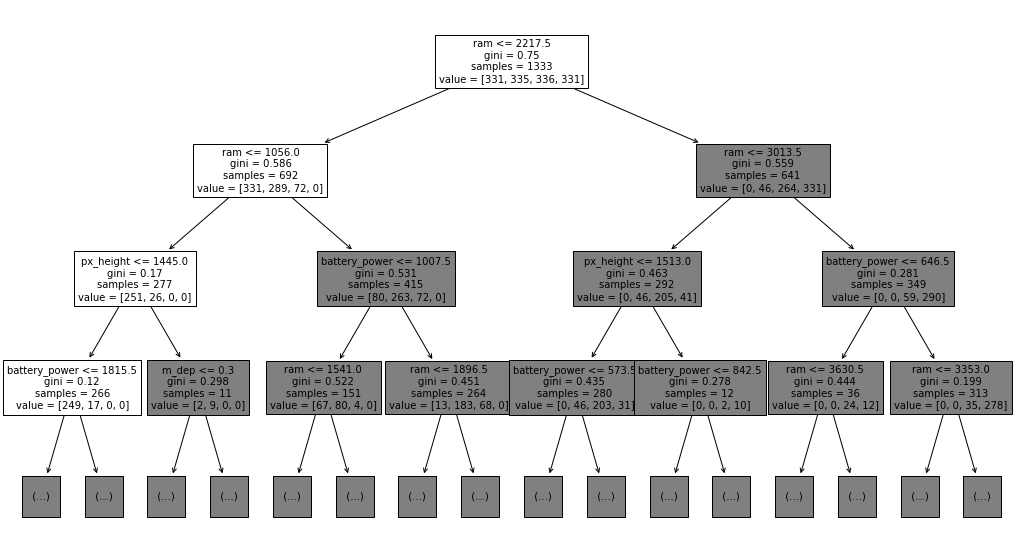

In [53]:
model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(X_train, y_train)
plt.figure(figsize=(18, 10))
plot_tree(model, feature_names=X.columns, max_depth=3, fontsize=10);

Qui possiamo vedere un esempio di decision tree ottenuto con questo algoritmo e come possiamo confermare le feature più importanti che "sfoltiscono" i dati nei nodi più vicini all'origine sono proprio **RAM**, **capienza batteria** e **pixel verticali dello schermo**.

### Random Forest

Come quinto modello utilizziamo **random forest**, questo algoritmo è simile al precedente, ma genera un insieme di alberi (foresta) che vengono poi combinati per ottenere dei risultati migliori. Valgono le stesse cose dette in precedenza per **decision tree**. Questo approccio si presta molto bene ad una eventuale parallelizzazione dei calcoli.

In [54]:
%%time
model = Pipeline([
    ("scaler", None),
    ("cl", RandomForestClassifier(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "cl__max_depth": range(1, 10)
    }
]
models["random_forest"] = train_and_evaluate(model, grid)

best score: 0.881559220389805
Wall time: 15.8 s


In [55]:
models["random_forest"].best_score_

0.8454464943985902

In [56]:
models["random_forest"].best_params_

{'cl__max_depth': 9, 'scaler': None}

In questo caso viene totalizzato un punteggio migliore con una profondità maggiore dell'albero, però sempre considerando che lo score totalizzato con il validation set è maggiore di quello dato dal training set possiamo aspettarci che l'overfitting sia minimo.

## Modelli di regressione

Fino ad ora ci siamo approcciati al problema come ad un problema di **classificazione**, perchè in effetti l'obiettivo che ci poniamo è quello di assegnare ad ogni istanza del problema una tra quattro classi.  
Nel nostro caso però la variabile target non è una variabile **categorica nominale**, ma **ordinale**, ciò significa che le classi possono essere ordinate, infatti sono fasce di prezzo: bassa < media < alta < molto alta.  
Nel dataset le quattro classi sono già rappresentate con i numeri da 0 a 3, in modo che sia già possibile capire l'ordine e applicare dei modelli di **regressione**.

In [57]:
#%pip install catboost

In [58]:
def accuracy(y_val, y_pred):
    return (y_pred == y_val).mean()

In [59]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost
print(catboost.__version__)
from catboost import CatBoostRegressor

1.0.6


### Regressione Lineare con feature polinomiali

Iniziamo con una semplice **regressione linera** con e senza **normalizzazione** e con una **trasformazione polinomiale** di grado 1, 2 o 3.  
Molti dei modelli di regressione che useremo (anche questo per esempio) trovano variabili continue, non discrete come la nostra, per cui per applicare effettivamente la classificazioni su dei dati dovremo arrotondare il risultato all'intero più vicino (0, 1, 2 o 3).

In [60]:
%%time
model = Pipeline([
    ("scaler", None),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", LinearRegression())
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree": range(1, 3)
    }
]
models["linear"] = train_and_evaluate(model, grid)

best score: 0.9192372736467825
Wall time: 474 ms


Applicando un algoritmo di regressione viene utilizzato come **score** per scegliere i miglior iperparametri nella grid search l'**R<sup>2</sup>** e l'algoritmo ci calcolerà valori continui, per cui avremo risultati del genere:

In [61]:
pd.Series(models["linear"].predict(X_val))

0      0.263225
1      1.772533
2      0.900749
3      2.984650
4      1.308607
         ...   
662    3.272516
663    0.947923
664    1.868439
665    2.764633
666    1.338251
Length: 667, dtype: float64

Per avere risultati corretti possiamo applicare un arrotondamento numpy e per esempio calcolare la percentuale di predizioni corrette (come calcolato nei modelli di classificazione visti precedentemente).

In [62]:
accuracy(y_val, np.round(models["linear"].predict(X_val)))

0.8950524737631185

Nonostante il metodo sia abbastanza approssimativo otteniamo dei risultati molto buoni con un algoritmo molto semplice!  
Poi ci occuperemo di misurare in modo più adeguato il modello in un momento successivo.

### Regressione Elastic Net

Procediamo aggiungendo all'algoritmo di regressione un meccanismo di **regolarizzazione** tramite **elastic net** così da utilizzare contemporaneamente regolarizzazione di tipo l1 e l2. 

In [63]:
%%time
model = Pipeline([
    ("scaler", None),
    ("reg", ElasticNet(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "reg__alpha": np.logspace(-2, 2, 5),
        "reg__l1_ratio": np.logspace(-2, 2, 5)
    }
]
models["elastic_net"] = train_and_evaluate(model, grid)

best score: 0.9199020801971314
Wall time: 2.57 s


In [64]:
accuracy(y_val, np.round(models["elastic_net"].predict(X_val)))

0.889055472263868

In [65]:
models["elastic_net"].best_params_

{'reg__alpha': 0.01, 'reg__l1_ratio': 10.0, 'scaler': None}

Vediamo l'efficacia che ha questo modello nella classificazione e gli iperparametri migliori.

## Kernel Ridge

A questo punto proviamo un'alternativa che utilizza il **kernel trick** e quindi diminuisce la complessità computazionale dell'algoritmo. I parametri rimangono comunque gli stessi:
- un parametro alpha per la **regolarizzazione**
- con o senza **normalizzazione**
- e **feature polinomiali** di grado 1 o 2

In [66]:
%%time
model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg",  KernelRidge(kernel="poly"))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "reg__alpha": np.logspace(-2, 2, 5),
        "reg__degree": range(1, 3)
    }
]
models["kernel_ridge"] = train_and_evaluate(model, grid)

C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\loren\anaconda3\lib\site-packages\sklearn\l

best score: 0.9191651414341464
Wall time: 4.71 s


In [67]:
accuracy(y_val, np.round(models["kernel_ridge"].predict(X_val)))

0.896551724137931

In [68]:
models["kernel_ridge"].best_score_

0.914630019230164

La funzione ci da un warning per il fatto che il numero di feature è troppo grande e il problema non è adatto a questo tipo di risoluzione (con feature polinomiali di grado 2).  Riportiamo i risultati, che sembrano corretti, vista la maggior accuratezza sul validation set rispetto al training set, ma comunque sia in fase di valutazione dei modelli scarteremo tutti quelli che utilizzano **feature polinomiali**, non solo per la poco affidabilità ma perchè abbiamo ottenuto risultati migliori con altri modelli.

### Decision Tree

In questo paragrafo e nel successivo vediamo nuovamente gli algoritmi **decision tree** e **random forest** ma utilizzando una regressione invece che una classificazione. Per questo motivo i ragionamenti rimangono analoghi a quelli fatti in precedenza.

In [69]:
%%time
model = Pipeline([
    ("scaler", None),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("cl", DecisionTreeRegressor(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree": range(1, 3),
        "cl__max_depth": range(1, 10)
    }
]
models["decision_tree_regr"] = train_and_evaluate(model, grid)

best score: 0.9051533936042111
Wall time: 6.49 s


In [70]:
accuracy(y_val, np.round(models["decision_tree_regr"].predict(X_val)))

0.856071964017991

### Random Forest

In [71]:
%%time
model = Pipeline([
    ("scaler", None),
    ("cl", RandomForestRegressor(random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "cl__max_depth": range(1, 10)
    }
]
models["random_forest_regr"] = train_and_evaluate(model, grid)

best score: 0.9390858547959876
Wall time: 25.7 s


In [72]:
accuracy(y_val, np.round(models["random_forest_regr"].predict(X_val)))

0.9055472263868066

### CatBoost Regressor

Infine vediamo l'utilizzo di un algoritmo che utilizza **gradient boosting**, cioè parte da un modello semplice e ad ogni step aggiunge una nuova funzione a quella creata allo step predente per ridurne l'errore. In particolare, **CatBoost** permette l'utilizzo di variabili categoriche, per cui è quello che fa più al caso nostro.

In [73]:
model = CatBoostRegressor(cat_features=binary_feature, n_estimators=2000)
%time model.fit(X_train, y_train)

Learning rate set to 0.024387
0:	learn: 1.0939869	total: 147ms	remaining: 4m 53s
1:	learn: 1.0735350	total: 149ms	remaining: 2m 29s
2:	learn: 1.0538073	total: 152ms	remaining: 1m 41s
3:	learn: 1.0352751	total: 154ms	remaining: 1m 16s
4:	learn: 1.0175276	total: 155ms	remaining: 1m 2s
5:	learn: 1.0012708	total: 157ms	remaining: 52.3s
6:	learn: 0.9828100	total: 159ms	remaining: 45.3s
7:	learn: 0.9644613	total: 164ms	remaining: 40.8s
8:	learn: 0.9486172	total: 166ms	remaining: 36.7s
9:	learn: 0.9317355	total: 168ms	remaining: 33.4s
10:	learn: 0.9152649	total: 170ms	remaining: 30.7s
11:	learn: 0.8992140	total: 172ms	remaining: 28.5s
12:	learn: 0.8835070	total: 174ms	remaining: 26.6s
13:	learn: 0.8684126	total: 179ms	remaining: 25.4s
14:	learn: 0.8532954	total: 183ms	remaining: 24.2s
15:	learn: 0.8398238	total: 187ms	remaining: 23.2s
16:	learn: 0.8249353	total: 193ms	remaining: 22.5s
17:	learn: 0.8109818	total: 195ms	remaining: 21.5s
18:	learn: 0.7966018	total: 197ms	remaining: 20.5s
19:	lea

193:	learn: 0.2417742	total: 612ms	remaining: 5.7s
194:	learn: 0.2414668	total: 614ms	remaining: 5.68s
195:	learn: 0.2411785	total: 616ms	remaining: 5.67s
196:	learn: 0.2408732	total: 618ms	remaining: 5.66s
197:	learn: 0.2405758	total: 623ms	remaining: 5.67s
198:	learn: 0.2401519	total: 627ms	remaining: 5.68s
199:	learn: 0.2398613	total: 629ms	remaining: 5.66s
200:	learn: 0.2395602	total: 631ms	remaining: 5.65s
201:	learn: 0.2392336	total: 633ms	remaining: 5.63s
202:	learn: 0.2389517	total: 635ms	remaining: 5.62s
203:	learn: 0.2386216	total: 638ms	remaining: 5.61s
204:	learn: 0.2382923	total: 640ms	remaining: 5.6s
205:	learn: 0.2379896	total: 642ms	remaining: 5.59s
206:	learn: 0.2377549	total: 644ms	remaining: 5.57s
207:	learn: 0.2374178	total: 645ms	remaining: 5.56s
208:	learn: 0.2371105	total: 647ms	remaining: 5.54s
209:	learn: 0.2368287	total: 649ms	remaining: 5.53s
210:	learn: 0.2365493	total: 654ms	remaining: 5.54s
211:	learn: 0.2362952	total: 655ms	remaining: 5.53s
212:	learn: 0.

409:	learn: 0.1978529	total: 1.08s	remaining: 4.21s
410:	learn: 0.1976452	total: 1.09s	remaining: 4.2s
411:	learn: 0.1974570	total: 1.09s	remaining: 4.2s
412:	learn: 0.1973457	total: 1.09s	remaining: 4.19s
413:	learn: 0.1971631	total: 1.09s	remaining: 4.19s
414:	learn: 0.1971044	total: 1.1s	remaining: 4.19s
415:	learn: 0.1968639	total: 1.1s	remaining: 4.18s
416:	learn: 0.1967643	total: 1.1s	remaining: 4.18s
417:	learn: 0.1966257	total: 1.1s	remaining: 4.17s
418:	learn: 0.1965004	total: 1.1s	remaining: 4.17s
419:	learn: 0.1963816	total: 1.1s	remaining: 4.16s
420:	learn: 0.1962512	total: 1.11s	remaining: 4.15s
421:	learn: 0.1960945	total: 1.11s	remaining: 4.15s
422:	learn: 0.1959432	total: 1.11s	remaining: 4.14s
423:	learn: 0.1957629	total: 1.11s	remaining: 4.14s
424:	learn: 0.1957118	total: 1.11s	remaining: 4.13s
425:	learn: 0.1956121	total: 1.12s	remaining: 4.13s
426:	learn: 0.1955395	total: 1.12s	remaining: 4.12s
427:	learn: 0.1953281	total: 1.12s	remaining: 4.12s
428:	learn: 0.195178

572:	learn: 0.1734478	total: 1.44s	remaining: 3.58s
573:	learn: 0.1732752	total: 1.44s	remaining: 3.58s
574:	learn: 0.1730522	total: 1.44s	remaining: 3.57s
575:	learn: 0.1729490	total: 1.45s	remaining: 3.57s
576:	learn: 0.1728135	total: 1.45s	remaining: 3.57s
577:	learn: 0.1726709	total: 1.45s	remaining: 3.57s
578:	learn: 0.1724894	total: 1.45s	remaining: 3.56s
579:	learn: 0.1723180	total: 1.46s	remaining: 3.56s
580:	learn: 0.1721467	total: 1.46s	remaining: 3.56s
581:	learn: 0.1720465	total: 1.46s	remaining: 3.56s
582:	learn: 0.1718740	total: 1.46s	remaining: 3.56s
583:	learn: 0.1717229	total: 1.47s	remaining: 3.55s
584:	learn: 0.1715564	total: 1.47s	remaining: 3.55s
585:	learn: 0.1714186	total: 1.47s	remaining: 3.55s
586:	learn: 0.1713189	total: 1.47s	remaining: 3.54s
587:	learn: 0.1711472	total: 1.47s	remaining: 3.54s
588:	learn: 0.1709160	total: 1.48s	remaining: 3.54s
589:	learn: 0.1707911	total: 1.48s	remaining: 3.53s
590:	learn: 0.1705614	total: 1.48s	remaining: 3.53s
591:	learn: 

771:	learn: 0.1482582	total: 1.87s	remaining: 2.98s
772:	learn: 0.1481326	total: 1.88s	remaining: 2.98s
773:	learn: 0.1480121	total: 1.88s	remaining: 2.98s
774:	learn: 0.1478885	total: 1.88s	remaining: 2.97s
775:	learn: 0.1477945	total: 1.88s	remaining: 2.97s
776:	learn: 0.1476268	total: 1.89s	remaining: 2.97s
777:	learn: 0.1474664	total: 1.89s	remaining: 2.96s
778:	learn: 0.1472603	total: 1.89s	remaining: 2.96s
779:	learn: 0.1471868	total: 1.89s	remaining: 2.96s
780:	learn: 0.1471335	total: 1.89s	remaining: 2.95s
781:	learn: 0.1470033	total: 1.89s	remaining: 2.95s
782:	learn: 0.1469034	total: 1.9s	remaining: 2.95s
783:	learn: 0.1467307	total: 1.9s	remaining: 2.95s
784:	learn: 0.1466749	total: 1.9s	remaining: 2.94s
785:	learn: 0.1465036	total: 1.9s	remaining: 2.94s
786:	learn: 0.1464168	total: 1.91s	remaining: 2.94s
787:	learn: 0.1462535	total: 1.91s	remaining: 2.93s
788:	learn: 0.1461121	total: 1.91s	remaining: 2.93s
789:	learn: 0.1459917	total: 1.91s	remaining: 2.93s
790:	learn: 0.14

939:	learn: 0.1292059	total: 2.24s	remaining: 2.52s
940:	learn: 0.1291099	total: 2.24s	remaining: 2.52s
941:	learn: 0.1290476	total: 2.24s	remaining: 2.52s
942:	learn: 0.1289753	total: 2.25s	remaining: 2.52s
943:	learn: 0.1288708	total: 2.25s	remaining: 2.52s
944:	learn: 0.1287613	total: 2.25s	remaining: 2.51s
945:	learn: 0.1286042	total: 2.25s	remaining: 2.51s
946:	learn: 0.1284849	total: 2.25s	remaining: 2.51s
947:	learn: 0.1283825	total: 2.25s	remaining: 2.5s
948:	learn: 0.1282171	total: 2.26s	remaining: 2.5s
949:	learn: 0.1281597	total: 2.26s	remaining: 2.5s
950:	learn: 0.1280342	total: 2.26s	remaining: 2.5s
951:	learn: 0.1279436	total: 2.26s	remaining: 2.49s
952:	learn: 0.1278158	total: 2.27s	remaining: 2.49s
953:	learn: 0.1277401	total: 2.27s	remaining: 2.49s
954:	learn: 0.1276987	total: 2.27s	remaining: 2.48s
955:	learn: 0.1276303	total: 2.27s	remaining: 2.48s
956:	learn: 0.1275726	total: 2.27s	remaining: 2.48s
957:	learn: 0.1275040	total: 2.28s	remaining: 2.48s
958:	learn: 0.12

1142:	learn: 0.1121483	total: 2.66s	remaining: 1.99s
1143:	learn: 0.1120797	total: 2.66s	remaining: 1.99s
1144:	learn: 0.1120141	total: 2.66s	remaining: 1.99s
1145:	learn: 0.1119884	total: 2.66s	remaining: 1.99s
1146:	learn: 0.1119749	total: 2.67s	remaining: 1.98s
1147:	learn: 0.1119275	total: 2.67s	remaining: 1.98s
1148:	learn: 0.1118586	total: 2.67s	remaining: 1.98s
1149:	learn: 0.1117547	total: 2.67s	remaining: 1.97s
1150:	learn: 0.1116858	total: 2.67s	remaining: 1.97s
1151:	learn: 0.1116008	total: 2.67s	remaining: 1.97s
1152:	learn: 0.1115130	total: 2.68s	remaining: 1.97s
1153:	learn: 0.1114323	total: 2.68s	remaining: 1.97s
1154:	learn: 0.1113946	total: 2.68s	remaining: 1.96s
1155:	learn: 0.1113557	total: 2.69s	remaining: 1.96s
1156:	learn: 0.1112754	total: 2.69s	remaining: 1.96s
1157:	learn: 0.1111796	total: 2.69s	remaining: 1.96s
1158:	learn: 0.1110859	total: 2.69s	remaining: 1.95s
1159:	learn: 0.1109750	total: 2.7s	remaining: 1.95s
1160:	learn: 0.1108093	total: 2.7s	remaining: 1

1321:	learn: 0.0994363	total: 3.14s	remaining: 1.61s
1322:	learn: 0.0993980	total: 3.14s	remaining: 1.61s
1323:	learn: 0.0993425	total: 3.14s	remaining: 1.6s
1324:	learn: 0.0992896	total: 3.14s	remaining: 1.6s
1325:	learn: 0.0992320	total: 3.15s	remaining: 1.6s
1326:	learn: 0.0992119	total: 3.15s	remaining: 1.6s
1327:	learn: 0.0991499	total: 3.15s	remaining: 1.6s
1328:	learn: 0.0991032	total: 3.16s	remaining: 1.59s
1329:	learn: 0.0990386	total: 3.16s	remaining: 1.59s
1330:	learn: 0.0990176	total: 3.16s	remaining: 1.59s
1331:	learn: 0.0989069	total: 3.16s	remaining: 1.58s
1332:	learn: 0.0988055	total: 3.17s	remaining: 1.58s
1333:	learn: 0.0987302	total: 3.17s	remaining: 1.58s
1334:	learn: 0.0986413	total: 3.17s	remaining: 1.58s
1335:	learn: 0.0986155	total: 3.17s	remaining: 1.57s
1336:	learn: 0.0985570	total: 3.17s	remaining: 1.57s
1337:	learn: 0.0985190	total: 3.17s	remaining: 1.57s
1338:	learn: 0.0984679	total: 3.17s	remaining: 1.57s
1339:	learn: 0.0983802	total: 3.18s	remaining: 1.56

1494:	learn: 0.0883332	total: 3.51s	remaining: 1.18s
1495:	learn: 0.0882677	total: 3.51s	remaining: 1.18s
1496:	learn: 0.0881962	total: 3.51s	remaining: 1.18s
1497:	learn: 0.0881568	total: 3.51s	remaining: 1.18s
1498:	learn: 0.0880689	total: 3.52s	remaining: 1.18s
1499:	learn: 0.0880122	total: 3.52s	remaining: 1.17s
1500:	learn: 0.0879333	total: 3.52s	remaining: 1.17s
1501:	learn: 0.0878834	total: 3.52s	remaining: 1.17s
1502:	learn: 0.0878405	total: 3.52s	remaining: 1.16s
1503:	learn: 0.0877653	total: 3.52s	remaining: 1.16s
1504:	learn: 0.0877067	total: 3.53s	remaining: 1.16s
1505:	learn: 0.0876500	total: 3.53s	remaining: 1.16s
1506:	learn: 0.0875601	total: 3.53s	remaining: 1.16s
1507:	learn: 0.0875187	total: 3.53s	remaining: 1.15s
1508:	learn: 0.0875150	total: 3.54s	remaining: 1.15s
1509:	learn: 0.0874831	total: 3.54s	remaining: 1.15s
1510:	learn: 0.0874187	total: 3.54s	remaining: 1.15s
1511:	learn: 0.0873297	total: 3.54s	remaining: 1.14s
1512:	learn: 0.0872537	total: 3.54s	remaining:

1700:	learn: 0.0768562	total: 3.93s	remaining: 691ms
1701:	learn: 0.0767758	total: 3.94s	remaining: 689ms
1702:	learn: 0.0767214	total: 3.94s	remaining: 687ms
1703:	learn: 0.0766897	total: 3.94s	remaining: 684ms
1704:	learn: 0.0766600	total: 3.94s	remaining: 682ms
1705:	learn: 0.0765871	total: 3.94s	remaining: 679ms
1706:	learn: 0.0765197	total: 3.94s	remaining: 677ms
1707:	learn: 0.0764985	total: 3.94s	remaining: 675ms
1708:	learn: 0.0764325	total: 3.95s	remaining: 672ms
1709:	learn: 0.0763900	total: 3.95s	remaining: 670ms
1710:	learn: 0.0763271	total: 3.95s	remaining: 667ms
1711:	learn: 0.0762604	total: 3.95s	remaining: 665ms
1712:	learn: 0.0761954	total: 3.96s	remaining: 663ms
1713:	learn: 0.0761680	total: 3.96s	remaining: 660ms
1714:	learn: 0.0761415	total: 3.96s	remaining: 658ms
1715:	learn: 0.0760880	total: 3.96s	remaining: 656ms
1716:	learn: 0.0760553	total: 3.96s	remaining: 653ms
1717:	learn: 0.0760259	total: 3.96s	remaining: 651ms
1718:	learn: 0.0759903	total: 3.96s	remaining:

1880:	learn: 0.0683463	total: 4.3s	remaining: 272ms
1881:	learn: 0.0682854	total: 4.3s	remaining: 269ms
1882:	learn: 0.0682277	total: 4.3s	remaining: 267ms
1883:	learn: 0.0681881	total: 4.3s	remaining: 265ms
1884:	learn: 0.0681534	total: 4.3s	remaining: 263ms
1885:	learn: 0.0681194	total: 4.31s	remaining: 260ms
1886:	learn: 0.0680821	total: 4.31s	remaining: 258ms
1887:	learn: 0.0680429	total: 4.31s	remaining: 256ms
1888:	learn: 0.0680055	total: 4.31s	remaining: 253ms
1889:	learn: 0.0679785	total: 4.31s	remaining: 251ms
1890:	learn: 0.0679082	total: 4.31s	remaining: 249ms
1891:	learn: 0.0678596	total: 4.32s	remaining: 246ms
1892:	learn: 0.0678499	total: 4.32s	remaining: 244ms
1893:	learn: 0.0678125	total: 4.32s	remaining: 242ms
1894:	learn: 0.0677818	total: 4.32s	remaining: 239ms
1895:	learn: 0.0677306	total: 4.32s	remaining: 237ms
1896:	learn: 0.0676773	total: 4.32s	remaining: 235ms
1897:	learn: 0.0676338	total: 4.33s	remaining: 232ms
1898:	learn: 0.0675876	total: 4.33s	remaining: 230m

In [74]:
models["catboost"] = model
model.score(X_val, y_val)

0.9410399680690266

In [75]:
accuracy(y_val, np.round(models["catboost"].predict(X_val)))

0.9265367316341829

## Reti Neurali

In questo breve paragrafo vediamo qualche esempio di rete neurale per trovare un modello al nostro problema.  
Non ci dilungheremo troppo dato che abbiamo già visto molti modelli, di classificazione e di regressione, alcuni già con ottimi risultati, ma nel caso fosse stato necessario si sarebbero potute aggiungere standardizzazione, regolarizzazione e diverse grid search con variazione degli iperparametri anche a questi modelli.

In [76]:
# se si utilizza Anaconda:
#%conda install tensorflow
# altrimenti
#%pip install tensorflow

In [77]:
import tensorflow
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

### Multi-Layered Perceptron

Qui per esempio vediamo utilizzato un **multi-layered Perceptron**, che come suggerisce il nome si basa sul primo algoritmo che abbiamo utilizzato, ma può implementari vari strati. Nel nostro caso ho eseguito qualche prova e ho scelto come iperparametri:
- un solo layer con 32 variabili
- la funzione di attivazione "relu"
- un numero massimo di iterazioni pari a 1000 (con meno non convergeva)
- e un batch size pari a 200

In [78]:
%%time
model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,), activation="relu", max_iter=1000, batch_size=200, random_state=42))
])
model.fit(X_train, y_train)
print(accuracy(y_val, model.predict(X_val)))
models["mlp"] = model

0.9280359820089955
Wall time: 2.81 s


### Rete neurale

In questa seconda parte vediamo invece una rete creata con TensorFlow. Per utilizzare la variabile target categorica dobbiamo trasformarla in rappresentazione **One-Hot**.

In [79]:
y_val_c , y_train_c = to_categorical(y_val), to_categorical(y_train)
y_train_c[:5, :]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [80]:
poly = PolynomialFeatures(degree=3)
X_train_p, X_val_p = poly.fit_transform(X_train), poly.fit_transform(X_val)

In questo caso la rete neurali è abbastanza efficiente da permetterci di trasformare l'input in forma polinomiale e allenare il modello in tempo ragionevole, per cui ne approfittiamo applicando una trasformazione di grado 3.

In [81]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train_p.shape[1]),
    Dense(64, activation="relu"),
    Dense(4, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               226816    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 235,332
Trainable params: 235,332
Non-trainable params: 0
_________________________________________________________________


Creiamo questa semplice rete neurale con 3 layer:
- un layer Dense a 128 variabili
- un layer Dense a 64 variabili
- un layer Dense a 4 variabili che distingue i risultati nelle 4 classi

Per l'algoritmo scegliamo come funzione di loss la "categorical crossentropy", ma visualizziamo anche una metrica a noi più chiara: l'**accuratezza**.

In [82]:
model.fit(X_train_p, y_train_c, batch_size=200 ,epochs=300)
models["neural_network"] = model

Epoch 1/300
7/7 [==============================] - 1s 11ms/step - loss: 91286344.0000 - accuracy: 0.4074
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 40615884.0000 - accuracy: 0.5124
Epoch 3/300
7/7 [==============================] - 0s 5ms/step - loss: 28552804.0000 - accuracy: 0.5049
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 22320462.0000 - accuracy: 0.5274
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 14266496.0000 - accuracy: 0.5911
Epoch 6/300
7/7 [==============================] - 0s 5ms/step - loss: 10128441.0000 - accuracy: 0.5911
Epoch 7/300
7/7 [==============================] - 0s 5ms/step - loss: 8274620.0000 - accuracy: 0.6092
Epoch 8/300
7/7 [==============================] - 0s 5ms/step - loss: 5794939.5000 - accuracy: 0.6482
Epoch 9/300
7/7 [==============================] - 0s 5ms/step - loss: 7145592.5000 - accuracy: 0.6084
Epoch 10/300
7/7 [==============================] - 0s 9ms/step - 

7/7 [==============================] - 0s 5ms/step - loss: 2804973.7500 - accuracy: 0.7434
Epoch 80/300
7/7 [==============================] - 0s 5ms/step - loss: 3916002.2500 - accuracy: 0.7299
Epoch 81/300
7/7 [==============================] - 0s 6ms/step - loss: 4449380.0000 - accuracy: 0.7262
Epoch 82/300
7/7 [==============================] - 0s 7ms/step - loss: 4518941.5000 - accuracy: 0.7089
Epoch 83/300
7/7 [==============================] - 0s 6ms/step - loss: 4197525.0000 - accuracy: 0.7217
Epoch 84/300
7/7 [==============================] - 0s 5ms/step - loss: 4676675.0000 - accuracy: 0.7097
Epoch 85/300
7/7 [==============================] - 0s 6ms/step - loss: 4428946.5000 - accuracy: 0.7262
Epoch 86/300
7/7 [==============================] - 0s 5ms/step - loss: 3536135.0000 - accuracy: 0.7179
Epoch 87/300
7/7 [==============================] - 0s 5ms/step - loss: 2914207.7500 - accuracy: 0.7397
Epoch 88/300
7/7 [==============================] - 0s 5ms/step - loss: 24492

7/7 [==============================] - 0s 6ms/step - loss: 1150028.1250 - accuracy: 0.8320
Epoch 158/300
7/7 [==============================] - 0s 8ms/step - loss: 1929806.0000 - accuracy: 0.7839
Epoch 159/300
7/7 [==============================] - 0s 7ms/step - loss: 2033565.8750 - accuracy: 0.7877
Epoch 160/300
7/7 [==============================] - 0s 7ms/step - loss: 1519229.0000 - accuracy: 0.8080
Epoch 161/300
7/7 [==============================] - 0s 6ms/step - loss: 1577741.6250 - accuracy: 0.8042
Epoch 162/300
7/7 [==============================] - 0s 5ms/step - loss: 1349815.2500 - accuracy: 0.7937
Epoch 163/300
7/7 [==============================] - 0s 6ms/step - loss: 1175025.1250 - accuracy: 0.8170
Epoch 164/300
7/7 [==============================] - 0s 5ms/step - loss: 1717046.5000 - accuracy: 0.7959
Epoch 165/300
7/7 [==============================] - 0s 7ms/step - loss: 1265898.6250 - accuracy: 0.8282
Epoch 166/300
7/7 [==============================] - 0s 5ms/step - lo

7/7 [==============================] - 0s 7ms/step - loss: 2542356.5000 - accuracy: 0.7697
Epoch 236/300
7/7 [==============================] - 0s 13ms/step - loss: 3312355.7500 - accuracy: 0.7322
Epoch 237/300
7/7 [==============================] - 0s 6ms/step - loss: 2549465.0000 - accuracy: 0.7614
Epoch 238/300
7/7 [==============================] - 0s 7ms/step - loss: 2344830.2500 - accuracy: 0.7847
Epoch 239/300
7/7 [==============================] - 0s 6ms/step - loss: 2049431.8750 - accuracy: 0.7929
Epoch 240/300
7/7 [==============================] - 0s 5ms/step - loss: 2332380.5000 - accuracy: 0.8065
Epoch 241/300
7/7 [==============================] - 0s 6ms/step - loss: 1706193.3750 - accuracy: 0.7959
Epoch 242/300
7/7 [==============================] - 0s 7ms/step - loss: 1400077.5000 - accuracy: 0.8207
Epoch 243/300
7/7 [==============================] - 0s 5ms/step - loss: 1199501.1250 - accuracy: 0.8140
Epoch 244/300
7/7 [==============================] - 0s 6ms/step - l

Come possiamo notare questa rete in particolare non raggiunge risultati entusiasmanti, sicuramente potrebbe essere migliorata con regolarizzazione e tuning degli iperparametri, ma come già detto, avendo già ottenuto un buon modello utilizzando algoritmi più semplici e interpretabili ci fermiamo qui con le reti neurali.

## Valutazione dei modelli

Una volta che abbiamo generato vari modelli diversi per predirre la fascia di prezzo dei cellulari dobbiamo decidere una o più misure della validità di questi modelli, per determinare quale sia il migliore.  
Come prima misura utilizziamo la più semplice ed immediata, che abbiamo considerato anche fino ad ora: l'**accuratezza**, cioè la percentuale di istanze che vengono correttamente classificate.

Introduciamo una misura dell'errore (che quindi dovrà essere minimizzata), il **Root Mean Square Error**.  
Questa misura può essere utile perchè classificare un telefono di fascia "molto alta" come "bassa" è un errore più grave che classificarlo come di fascia "alta" e questa formula tiene conto di ciò.

In [83]:
def rmse(y_val, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_val)))

### Precision, Recall e F1-Score

Un'altra misura importante nella classificazione è l'**F1-Score**, questa misura è derivata dalla **precision** e dalla **recall**.

In [84]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [85]:
#prendiamo uno dei modelli come esempio
y_pred = models["decision_tree"].predict(X_val)
conf_matrix = pd.DataFrame(confusion_matrix(y_val, y_pred))
conf_matrix

,0,1,2,3
0,152,17,0,0
1,15,141,9,0
2,0,23,130,11
3,0,0,24,145


Nella **matrice di confusione** possiamo vedere lungo le righe le classi reali di ogni istanza e lungo le colonne le classi predette, per cui lungo la diagonale abbiamo le classi che vengono classificate correttamente.  
Per esempio il "15" indica che 15 cellulari della fascia media sono stati classificati erroneamente come cellulari della fascia bassa.

In [86]:
precision_score(y_val, y_pred, average="macro")

0.8540545893343898

In [87]:
np.mean([conf_matrix.iloc[i,i] / conf_matrix.iloc[:,i].sum() for i in range(0, 4)])

0.8540545893343898

Come abbiamo verificato empiricamente la **precision** è la media della precision di ogni classe, che è calcolato come:
$$
\frac{TP}{TP + FP}
$$
Questo è sempre così nel caso di classificazione binaria, nel nostro caso multivariato dobbiamo specificare "macro" perché sia la media tra le precision di ogni classe.

In [88]:
recall_score(y_val, y_pred, average="macro")

0.8511562077697163

In [89]:
np.mean([conf_matrix.iloc[i,i] / conf_matrix.iloc[i,:].sum() for i in range(0, 4)])

0.8511562077697163

La **recall** di ogni classe si calcola, invece, come:
$$
\frac{TP}{TP + FN}
$$  
Per ottenere quella "globale" si applica sempre la media tra ciascuna delle singole classi.

In [90]:
f1_score(y_val, y_pred, average="macro")

0.8518013831107112

Infine l'**F1-Score** viene calcolato per la classe C come:
$$
\frac{2 * recall(C) * precision(C)}{recall(C) + precision(C)}
$$
Per quello "globale" viene fatta la media di quelli di tutte le classi.

In [91]:
def print_eval(y_val, y_pred):
    print(f"Accuracy: {accuracy(y_val, y_pred)}")
    print(f"    RMSE: {rmse(y_val.astype(int), y_pred)}")
    print(f"F1-Score: {f1_score(y_val, y_pred, average='macro')}\n")

In [92]:
for name, model in models.items():
    print(name)
    if(name != "neural_network"):
        print_eval(y_val, np.round(model.predict(X_val)))
    else:
        print_eval(y_val_c, np.round(model.predict(X_val_p)))

perceptron
Accuracy: 0.9130434782608695
    RMSE: 0.29488391230979427
F1-Score: 0.9119201319429217

logistic_regression
Accuracy: 0.974512743628186
    RMSE: 0.15964728739259584
F1-Score: 0.9744106266055345

svm
Accuracy: 0.9775112443778111
    RMSE: 0.14996251405664318
F1-Score: 0.9773913230997028

decision_tree
Accuracy: 0.8515742128935532
    RMSE: 0.3852606742277841
F1-Score: 0.8518013831107112

random_forest
Accuracy: 0.881559220389805
    RMSE: 0.34415226224767853
F1-Score: 0.8803396413839334

linear
Accuracy: 0.8950524737631185
    RMSE: 0.3239560560274828
F1-Score: 0.6029139258334534

elastic_net
Accuracy: 0.889055472263868
    RMSE: 0.3330833645442713
F1-Score: 0.5989959965124566

kernel_ridge
Accuracy: 0.896551724137931
    RMSE: 0.32163376045133846
F1-Score: 0.6039307325707391

decision_tree_regr
Accuracy: 0.856071964017991
    RMSE: 0.3793784864512074
F1-Score: 0.8561726608806857

random_forest_regr
Accuracy: 0.9055472263868066
    RMSE: 0.3073316996555894
F1-Score: 0.90499

In [97]:
best = ["svm", "logistic_regression", "mlp", "catboost"]

Visti i risultati ottenuti possiamo dire che i migliori modelli sono quelli ottenuti con **regressione logistica** e **SVM**, ma anche **catBoost**, nonostante sia un'algoritmo di regressione, ha raggiunto un ottimo risultato e risulta come il quarto migliore (considerando anche **multi-layered perceptron** che arriva terzo).

## Considerazioni Finali

### Conoscienza appresa

Ottenuti buoni risultati con alcuni dei modelli utilizzati ci chiediamo quale conoscienza possiamo apprendere da questi modelli.

In [98]:
pd.Series(models["catboost"].feature_importances_, index=X.columns).sort_values(ascending=False)

ram              64.338424
battery_power    10.947900
px_width          5.793982
px_height         5.513066
mobile_wt         1.927958
int_memory        1.542440
sc_h              1.204830
clock_speed       1.198285
pc                1.189426
talk_time         1.115183
n_cores           1.091415
m_dep             1.024553
fc                0.982709
sc_w              0.854539
touch_screen      0.280584
dual_sim          0.250454
four_g            0.201398
wifi              0.185485
three_g           0.179495
blue              0.177872
dtype: float64

Qui, grazie al parametro **feature_importances_** dei modelli **random forest**, ma in questo caso utilizzato con il modello **catBoost** possiamo vedere quanto una feature è ricorrente negli alberi decisionali creati, quindi quanto è significativa.  
Come possiamo verificare ancora una volta i parametri più significativi rimangono quelli che fin dall'inizio hanno mostrato una più alta correlazione con la variabile target: **RAM**, **capienza batteria** e **risoluzione dello schermo** (pixel orizzontali e verticali).

### Analisi della confidenza

Vogliamo una formula che ci calcoli la reale accuratezza di un modello data la sua **accuratezza**, il numero **N** di elemnti e un valore **Z** calcolato rispetto alla confidenza che vogliamo ottenere.

In [99]:
def confidence(accuracy, N, z):
    variation = z * np.sqrt((accuracy / N) - (accuracy**2 / N) + z**2 / (4 * N**2))
    base_num = accuracy + (z**2 / (2 * N))
    den = 1 + (z**2 / N)
    min_conf = (base_num - variation) / den
    max_conf = (base_num + variation) / den
    return min_conf, max_conf

In [100]:
N = 1000
#per confidenza =95%
z = 1.96

for name in best:
    print(name)
    model = models[name]
    acc = accuracy(y_val, np.round(model.predict(X_val)))
    min_c, max_c = confidence(acc, N, z)
    print(f"Min: {min_c}")
    print(f"Max: {max_c}\n")

svm
Min: 0.9663315260520816
Max: 0.9850361884913507

logistic_regression
Min: 0.9627797387572606
Max: 0.9826139242034814

mlp
Min: 0.910327356460681
Max: 0.9424685069683612

catboost
Min: 0.9086825903624947
Max: 0.9411262472752023



### Miglior modello

Come notiamo facilmente dall'intervallo di accuratezza dei 4 modelli migliori **regressione logistica** e **support vector machine** hanno raggiunto valori molto alti (da ~96% a ~98%) con una confidenza del 95% su 1000 elementi.  
Mi ritengo perciò soddisfatto del risultato raggiunto e, anche se di poco, possiamo dire che il modello migliore è quello che ha utilizza **support vector machines**!